# BIDIRECTIONAL LSTM WITH ATTENTION

In [165]:
import utils
import numpy as np
import io
import nltk
import keras as k
from sklearn.metrics import f1_score,accuracy_score
from keras.layers.embeddings import Embedding
from keras.layers import Input, Dense, merge, Dropout, RepeatVector, Activation, merge, Lambda, Flatten, Reshape
from keras.layers import LSTM, Bidirectional, TimeDistributed, GRU, concatenate
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras import optimizers
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
import string
import argparse
from collections import Counter
import re
import argparse
import json
import sys
from ipynb.fs.full.Preprocess import splitDatasets, splitValDatasets,vectorizeValData, vectorizeData
from ipynb.fs.full.Attention import Attention

# Creating word embeddings with glove

In [8]:
embeddings_index = {}
f = open( 'glove.6B.100d.txt',encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Import train and dev datasets

In [9]:
with open('train-v2.0.json') as json_data:
    d = json.load(json_data)
trainData = d['data']

In [10]:
tContext, tQuestion, tQuestion_id, tAnswerBegin, tAnswerEnd, tAnswerText, maxLenTContext, maxLenTQuestion = splitDatasets(trainData)

In [11]:
with open('dev-v2.0.json') as json_data:
    d = json.load(json_data)
valData = d['data']

In [36]:
te_Context, te_Question, te_Question_id, te_AnswerBegin, te_AnswerEnd, te_AnswerText, te_maxLenTContext, te_maxLenTQuestion = splitDatasets(valData)

In [71]:
vContext, vToken2CharIdx, vContextOriginal, vQuestion, vQuestion_id, maxLenVContext, maxLenVQuestion = splitValDatasets(valData)

# Creation of vocabulary

In [13]:
vocab = {}
for words in tContext + tQuestion + vContext + vQuestion:
    for word in words:
        if word not in vocab:
            vocab[word] = 1
vocab = sorted(vocab.keys()) 

In [14]:
vocab_size = len(vocab) + 1
print(vocab_size)
word_index = dict((c, i + 1) for i, c in enumerate(vocab))
context_maxlen = max(maxLenTContext, maxLenVContext)
question_maxlen = max(maxLenTQuestion, maxLenVQuestion)

107339


# Vectorize train and datasets

In [15]:
tX, tXq, tYBegin, tYEnd = vectorizeData(tContext, tQuestion, tAnswerBegin, tAnswerEnd, word_index, context_maxlen, question_maxlen)

In [57]:
vX, vXq, vYBegin, vYEnd = vectorizeData(te_Context, te_Question, te_AnswerBegin, te_AnswerEnd, word_index, context_maxlen, question_maxlen)


# Creation of embedding for Question and Context

In [18]:
nb_words = len(word_index)
EMBEDDING_DIM = 100
MAX_SEQUENCE_LENGTH = context_maxlen

embedding_matrix = np.zeros((nb_words+1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(nb_words,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

# MODEL CREATION

In [19]:
question_input = Input(shape=(question_maxlen,), dtype='int32', name='question_input')
context_input = Input(shape=(context_maxlen,), dtype='int32', name='context_input')
questionEmbd = Embedding(output_dim=EMBEDDING_DIM, input_dim=vocab_size,
                         mask_zero=True, weights=[embedding_matrix], 
                         input_length=question_maxlen, trainable=False)(question_input)
contextEmbd = Embedding(output_dim=EMBEDDING_DIM, input_dim=vocab_size,
                         mask_zero=True, weights=[embedding_matrix], 
input_length=context_maxlen, trainable=False)(context_input)

In [21]:
Q = Bidirectional(LSTM(128, return_sequences=True))(questionEmbd)
D = Bidirectional(LSTM(128, return_sequences=True))(contextEmbd)
Q2 = Attention(question_maxlen)(Q)
D2 = Attention(context_maxlen)(D)
L = concatenate([D2, Q2], axis=1)
answerPtrBegin_output = Dense(context_maxlen, activation='softmax')(L)
Lmerge = concatenate([L, answerPtrBegin_output],axis = 1)
answerPtrEnd_output = Dense(context_maxlen, activation='softmax')(Lmerge)
model = Model(input=[context_input, question_input], output=[answerPtrBegin_output, answerPtrEnd_output])
am = optimizers.Adam(lr=0.0005)
model.compile(optimizer=am, loss='categorical_crossentropy',
              loss_weights=[.04, 0.04], metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
context_input (InputLayer)      (None, 766)          0                                            
__________________________________________________________________________________________________
question_input (InputLayer)     (None, 60)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 766, 100)     10733900    context_input[0][0]              
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 60, 100)      10733900    question_input[0][0]             
__________________________________________________________________________________________________
bidirectio

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:20: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


Model starts from 51st epoch. 51 epochs were run previously, this model resumes from previous run.

In [166]:
train_slice = 10000
filepath="modelweightsfinal.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
model_history = model.fit([tX, tXq], [tYBegin, tYEnd],batch_size= 128, verbose=2,
                          callbacks = callbacks_list,epochs=30)

Epoch 1/30
 - 186s - loss: 0.2310 - dense_1_loss: 2.8946 - dense_2_loss: 2.8810 - dense_1_acc: 0.3359 - dense_2_acc: 0.3401
Epoch 3/30
 - 187s - loss: 0.2168 - dense_1_loss: 2.7180 - dense_2_loss: 2.7022 - dense_1_acc: 0.3732 - dense_2_acc: 0.3805
Epoch 4/30
 - 187s - loss: 0.2052 - dense_1_loss: 2.5765 - dense_2_loss: 2.5525 - dense_1_acc: 0.4099 - dense_2_acc: 0.4255
Epoch 5/30
 - 187s - loss: 0.1942 - dense_1_loss: 2.4419 - dense_2_loss: 2.4122 - dense_1_acc: 0.4452 - dense_2_acc: 0.4597
Epoch 6/30
 - 187s - loss: 0.1874 - dense_1_loss: 2.3573 - dense_2_loss: 2.3283 - dense_1_acc: 0.4654 - dense_2_acc: 0.4802
Epoch 7/30
 - 187s - loss: 0.1761 - dense_1_loss: 2.2175 - dense_2_loss: 2.1839 - dense_1_acc: 0.5030 - dense_2_acc: 0.5191
Epoch 8/30
 - 187s - loss: 0.1680 - dense_1_loss: 2.1166 - dense_2_loss: 2.0827 - dense_1_acc: 0.5303 - dense_2_acc: 0.5477
Epoch 9/30
 - 187s - loss: 0.1598 - dense_1_loss: 2.0166 - dense_2_loss: 1.9773 - dense_1_acc: 0.5618 - dense_2_acc: 0.5750
Epoch 10

Save Model

In [167]:
model_json = model.to_json()
with open("model_final.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_final.h5")

# Predictions with test data

In [190]:
predictions = model.predict([vX, vXq], batch_size=128)
print(predictions[0].shape, predictions[1].shape)

(20302, 766) (20302, 766)


Answer Tokens are extracted with answer begin, end and joint 

In [191]:
ansBegin = np.zeros((predictions[0].shape[0],), dtype=np.int32)
ansEnd = np.zeros((predictions[0].shape[0],),dtype=np.int32) 
for i in range(predictions[0].shape[0]):
	ansBegin[i] = predictions[0][i, :].argmax()
	ansEnd[i] = predictions[1][i, :].argmax()
print(ansBegin.min(), ansBegin.max(), ansEnd.min(), ansEnd.max())
answers = {}
for i in range(len(vQuestion_id)):
    if ansBegin[i] >= len(vContext[i]):
        answers[vQuestion_id[i]] = ""
    elif ansEnd[i] >= len(vContext[i]):
        answers[vQuestion_id[i]] = vContextOriginal[i][vToken2CharIdx[i][ansBegin[i]]:]
    else:
        answers[vQuestion_id[i]] = vContextOriginal[i][vToken2CharIdx[i][ansBegin[i]]:vToken2CharIdx[i][ansEnd[i]]+len(vContext[i][ansEnd[i]])]

0 282 0 284


Saving answers to json file

In [192]:
with io.open('answers_final.json', 'w', encoding='utf-8') as f:
    f.write((json.dumps(answers, ensure_ascii=False)))

# MODEL PERFORMANCE:

Model performance on training accuracy and loss for Answer begin and end dense layers are visualized

In [241]:
def plot_modelacc(fit_model):
    with p.style.context('ggplot'):
            p.plot(fit_model.history['dense_1_acc'])
            p.plot(fit_model.history['dense_2_acc'])
            p.title("MODEL ACCURACY")
            p.xlabel("# of EPOCHS")
            p.ylabel("ACCURACY")
            p.legend(['begin answer','end answer'],loc='upper left')
    return p.show()

In [244]:
def plot_model_loss(fit_model):
    with p.style.context('ggplot'):
            p.plot(fit_model.history['dense_1_loss'])
            p.plot(fit_model.history['dense_2_loss'])
            p.title("MODEL LOSS")
            p.xlabel("# of EPOCHS")
            p.ylabel("LOSS")
            p.legend(['begin answer', 'end answer'], loc='upper left')
    return p.show()

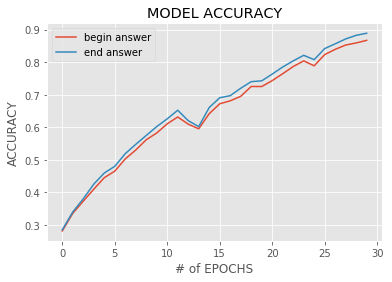

In [243]:
import matplotlib.pyplot as p
plot_modelacc(model_history)

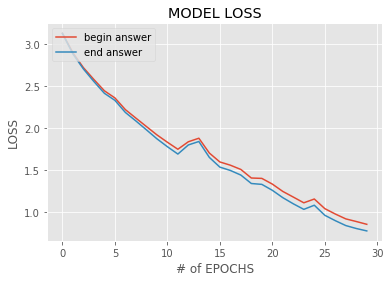

In [245]:
plot_model_loss(model_history)

# Evaluation of Model: F1 Score

In [215]:
def f1_eval():
    begin = f1_score(te_AnswerBegin,ansBegin,average="macro")
    end = f1_score(te_AnswerEnd,ansBegin,average="macro")
    f1 = (begin + end) * 100
    return f1

In [217]:
f1 = f1_eval()
print("MODEL F1 SCORE")
f1

MODEL F1 SCORE


/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.9480303342457967

# TESTING MODEL

In [270]:
def chatbot(number):
    Q = te_Question[number]
    C = (list(te_Context[number]))
    qid = te_Question_id[number]
    for id,ans in answers.items():   
        if id == qid:
            A= (ans)
    return Q,C,A
    

Example 

In [306]:
Q,C,A = chatbot(1)

In [3]:
print("Question")
print(' '.join(Q))

Question
who was the duke in the battle of hastings ?


In [2]:
print("Context")
print(' '.join(Q))

Context
the norman dynasty had a major political , cultural and military impact on medieval europe and even the near east . the normans were famed for their martial spirit and eventually for their christian piety , becoming exponents of the catholic orthodoxy into which they assimilated . they adopted the gallo-romance language of the frankish land they settled , their dialect becoming known as norman , normaund or norman french , an important literary language . the duchy of normandy , which they formed by treaty with the french crown , was a great fief of medieval france , and under richard i of normandy was forged into a cohesive and formidable principality in feudal tenure . the normans are noted both for their culture , such as their unique romanesque architecture and musical traditions , and for their significant military accomplishments and innovations . norman adventurers founded the kingdom of sicily under roger ii after conquering southern italy on the saracens and byzantines

In [324]:
print("Answer")
print(A)

Answer
Christian piety
